#### Laurent Jutras-Dubé

## Model of light-induced hESC colony patterning

####   

This Jupyter notebook simulates the mathematical model of the paper titled "Optogenetic-Programmable Human Embryo Models Elucidate the Interplay Between Tissue Architecture and BMP4 Signaling at the Onset of Gastrulation" by Riccardo De Santis, Laurent Jutras-Dubé, Sophia Bourdrel, Eleni Rice, Francesco Piccolo, and Ali H. Brivanlou.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import ode
from matplotlib.animation import (FuncAnimation, writers)

import OptoBMP4_functions as fct

<br>

We first write a parameter dictionary that lists all parameters required for modeling the dynamics of BMP4, WNT and NODAL signaling.

In [4]:
param = {
    
    # BMP
    "p_BMP4"     : 0.1,
    "D_BMP4"     : 0.1,
    "l_BMP4"     : 0.002,
    "x_light"    : 250.,
    "fixed_BMP4" : 0.,
    
    # Noggin
    "p_NOG" : 0.07,
    "D_NOG" : 10.,
    "l_NOG" : 0.001,
    "a"        : 1.,
    
    # Wnt
    "p1_WNT3" : 0.1,
    "p2_WNT3" : 0.01,
    "D_WNT3"  : 4.,
    "l_WNT3"  : 0.005,
    "T_WNT3"  : 3.6,
    
    # Nodal
    "p_NODAL" : 0.13,
    "D_NODAL" : 1.,
    "l_NODAL" : 0.002,

    # pSMAD1
    "n_pSMAD1" : 1.4,
    "K_pSMAD1" : 35.,
    
    # YAP
    "n_nYAP" : 2.5,
    "K_nYAP" : 0.975,
    "fixed_nYAP" : 0.,

    # bCatenin
    "n_bCAT" : 3.6,
    "K_bCAT" : 20.,

    # pSMAD2
    "n_pSMAD2" : 2.,
    "K_pSMAD2" : 20.,

    # SOX2
    "n_SOX2"  : 8.,
    "K_SOX2"  : 0.5,
    "n2_SOX2" : 8.,
    "K2_SOX2" : 0.5,

    # ISL1
    "n_ISL1" : 8.,
    "K_ISL1" : 0.5,

    # BRA
    "n_BRA"  : 8.,
    "K_BRA"  : 0.5,
    "n2_BRA" : 8.,
    "K2_BRA" : 0.5,
    "n3_BRA" : 8.,
    "K3_BRA" : 0.5,
    
    # Array size, time points, and radius
    "times"     : np.linspace(0.1, 5e3, 500),
    "x_total"   : 250.,
    "x_arr_len" : 300,

    # Modeling micropatterns?
    "micro" : False
    
}

<br>

In micropatterns, the sensisitivity to BMP4 depends on the distance from the micropattern's edge. Similarly to our previous mathematical model (Etoc et al., 2016), we capture this dependency, as well as the tension parameter, through the following functions.

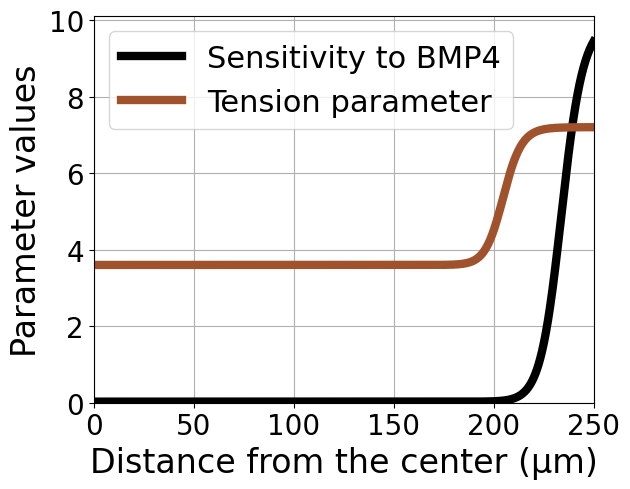

In [3]:
# Compute the edge-dependent parameters
param["micro"], param["fixed_BMP4"], param["x_total"] = True, 50., 250.
x = np.linspace(0., param["x_total"], 1000)
K_MPF, T_MPF = fct.compute_edge_parameters(x, param)

# Generate the figure
fig, ax = plt.subplots(figsize=[6.4, 5.])

ax.plot(x, 1./K_MPF, c='k', lw=6, label='Sensitivity to BMP4')
ax.plot(x, T_MPF, c='sienna', lw=6, label='Tension parameter')
ax.set_xlabel('Distance from the center (µm)', fontsize=24)
ax.set_ylabel('Parameter values', fontsize=24)
ax.set_xlim(0., param["x_total"])
ax.set_ylim(0., 10.1)
ax.tick_params(labelsize=20)
ax.grid()
ax.legend(fontsize=22)

fig.tight_layout()
fig.savefig('Figures/FIG4B_micropattern_edge_parameter_values.pdf', dpi=300)

<br>

In regular culture, the tension parameter is homogeneous due to the absence of a physical edge, but can be modulated by epithelial domain reorganization. Moreover, the sensisitivity to BMP4 depends on the distance from the edge of the illuminated region. We capture this dependency through the following function.

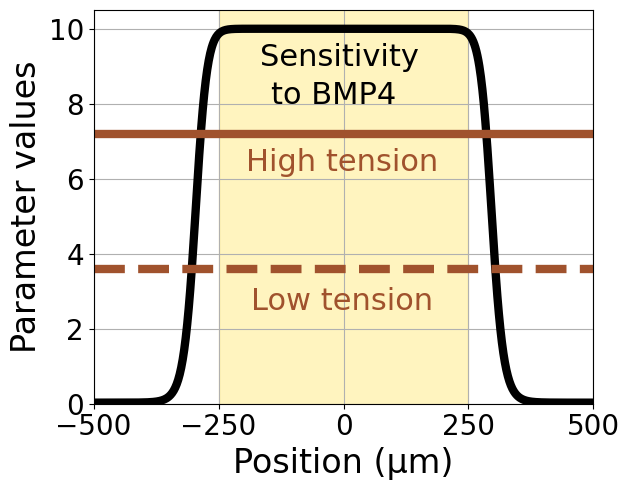

In [4]:
# Compute the edge-dependent parameters
param["micro"], param["x_total"], param["x_light"] = False, 500., 250.
x = np.linspace(-param["x_total"], param["x_total"], 1000)
K_RCL, T_RCL = fct.compute_edge_parameters(x, param)

# Generate the figure
fig, ax = plt.subplots(figsize=[6.4, 5.])

# Edge-dependent BMP4 parameter (pSMAD1 sensitivity to BMP4 induction)
ax.plot(x, 1./K_RCL, c='k', lw=6, label='Sensitivity to BMP4')
ax.plot([-param["x_total"], param["x_total"]], [7.2, 7.2], c='sienna', lw=6, label='Tension parameter,\nhigh tension')
ax.plot([-param["x_total"], param["x_total"]], [3.6, 3.6], c='sienna', ls='--', lw=6, label='Low tension')
ax.set_xlabel('Position (µm)', fontsize=24)
ax.set_ylabel('Parameter values', fontsize=24)
ax.set_xlim(-param["x_total"], param["x_total"])
ax.set_ylim(0., 10.5)
ax.set_xticks([-500., -250., 0., 250., 500.])
ax.tick_params(labelsize=20)
ax.grid()
# ax.legend(fontsize=18)

ax.fill_between([-param["x_light"], param["x_light"]], [-1.,-1.], [65.,65.], color='gold', alpha=0.25)
ax.text(-167., 9., 'Sensitivity', c='k', fontsize=22)
ax.text(-145., 8., 'to BMP4', c='k', fontsize=22)
ax.text(-195., 6.2, 'High tension', c='sienna', fontsize=22)
ax.text(-185., 2.5, 'Low tension', c='sienna', fontsize=22)

fig.tight_layout()
fig.savefig('Figures/FIG4C_regular_culture_parameter_values.pdf', dpi=300)

<br>

To model the dynamics of morphogens, transcription factors, and fate markers, we use the `get_results` function, which calls the `integrate` function, which integrates the partial differential equations (PDEs) found in the `PDEs` function. We then use the plotting functions to visualize the results.

<!-- In regular cultures, there is obviously no micropattern edge to speak of, and thus the boundary conditions for diffusing particles are different than with micropatterned substrates. We use reflective boundary conditions at the borders (walls) of the regular cultures, while we set the concentration of diffusing particles to 0 at the edge of the micropatterns, since there, diffusing particles get diluted (lost) in the media. Also note that when modelling BMP4 and Nodal dynamics within micropatterns, the spatial coordinate represents the distance from the center $r$, and thus the diffusion term has an extra term compared to the diffusion term for regular cell cultures.  -->

#### 1. Modeling soluble BMP4 presentation in micropatterns

In [5]:
# Spatial parameters
param["x_arr_len"] = 300
param["x_total"] = 250.

# PDE parameters
param["micro"] = True
param["fixed_BMP4"] = 50.
param["T_WNT3"] = 3.6
param["fixed_nYAP"] = 0.
param["p_NOG"] = 0.07

x_MPF, morphogens_MPF, TFs_MPF, fates_MPF = fct.get_results(param)

<br>

Figures

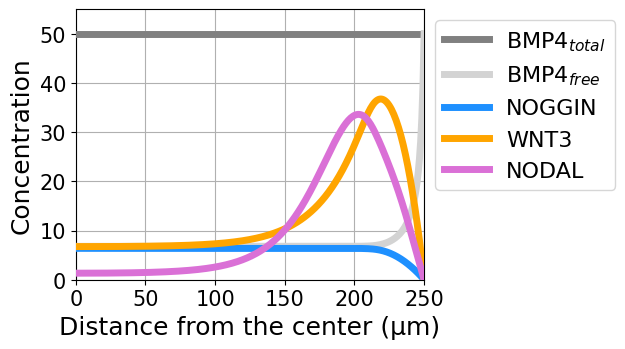

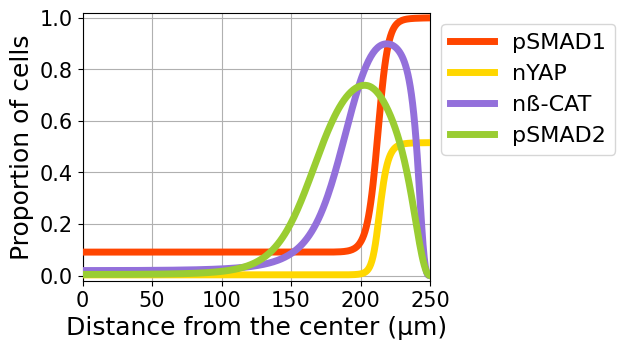

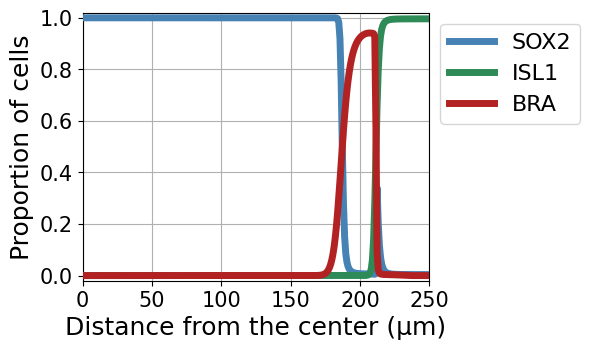

In [6]:
fct.plot_morphogens(x_MPF, morphogens_MPF[:,-1], 'Micropattern_solubleBMP4', micro=True, fixed_BMP4=True)
fct.plot_TFs(x_MPF, TFs_MPF[:,-1], 'Micropattern_solubleBMP4', micro=True, fixed_BMP4=True)
fct.plot_fates(x_MPF, fates_MPF[:,-1], 'Micropattern_solubleBMP4', micro=True, fixed_BMP4=True)

<br>



#### 2. Modeling light-activated BMP4 in regular cultures in the low-tension regime

In [7]:
# Spatial parameters
param["x_arr_len"] = 1000
param["x_total"] = 3700.

# PDE parameters
param["micro"] = False
param["fixed_BMP4"] = 0.
param["T_WNT3"] = 3.6
param["fixed_nYAP"] = 0.
param["p_NOG"] = 0.07

x_RCLL, morphogens_RCLL, TFs_RCLL, fates_RCLL = fct.get_results(param)

/Users/brivanloulab/Documents/POST-DOC/Pattern_Formation/OptoBMP4_functions.py:131: RuntimeWarning: invalid value encountered in power
  pSMAD1 = free_BMP4**n_pSMAD1/(free_BMP4**n_pSMAD1+K_pSMAD1**n_pSMAD1)


<br>

Figures

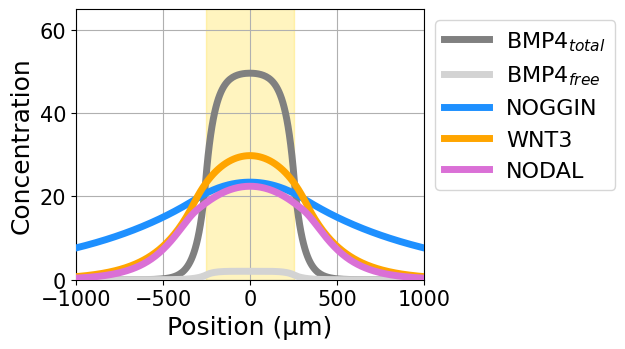

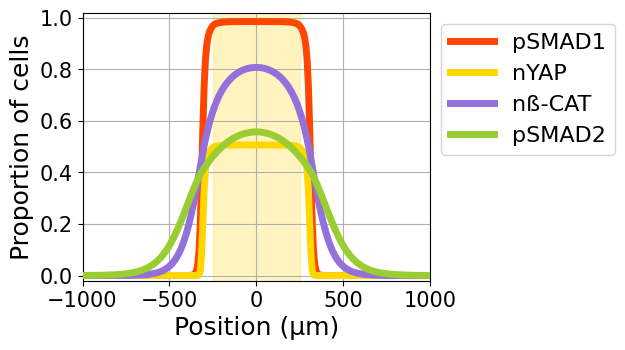

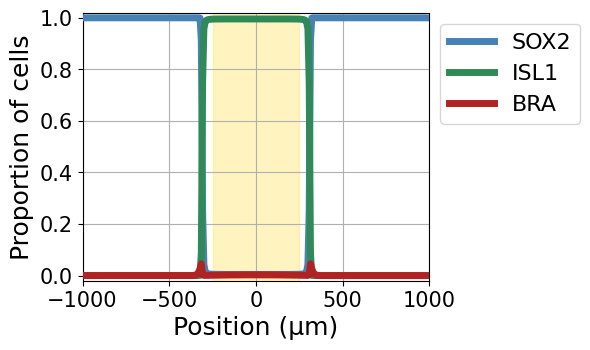

In [8]:
fct.plot_morphogens(x_RCLL, morphogens_RCLL[:,-1], 'RegularCulture_lightBMP4_lowtension', x_light=param["x_light"], micro=False)
fct.plot_TFs(x_RCLL, TFs_RCLL[:,-1], 'RegularCulture_lightBMP4_lowtension', x_light=param["x_light"], micro=False)
fct.plot_fates(x_RCLL, fates_RCLL[:,-1], 'RegularCulture_lightBMP4_lowtension', x_light=param["x_light"], micro=False)

<br>



#### 3. Modeling light-activated BMP4 in regular cultures in the high-tension regime

In [5]:
# Spatial parameters
param["x_arr_len"] = 1000
param["x_total"] = 3700.

# PDE parameters
param["micro"] = False
param["fixed_BMP4"] = 0.
param["T_WNT3"] = 7.2
param["fixed_nYAP"] = 0.
param["p_NOG"] = 0.07

x_RCLH, morphogens_RCLH, TFs_RCLH, fates_RCLH = fct.get_results(param)

/Users/brivanloulab/Documents/POST-DOC/Pattern_Formation/OptoBMP4_functions.py:131: RuntimeWarning: invalid value encountered in power
  pSMAD1 = free_BMP4**n_pSMAD1/(free_BMP4**n_pSMAD1+K_pSMAD1**n_pSMAD1)


<br>

Figures

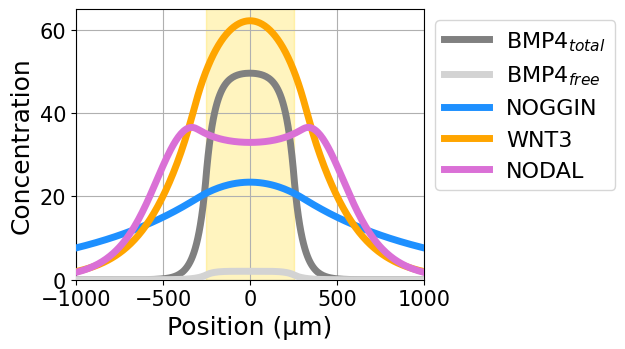

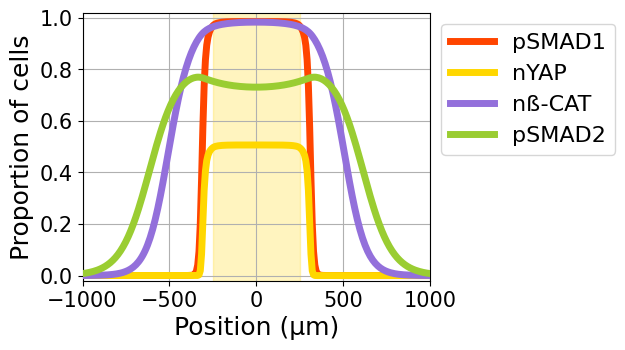

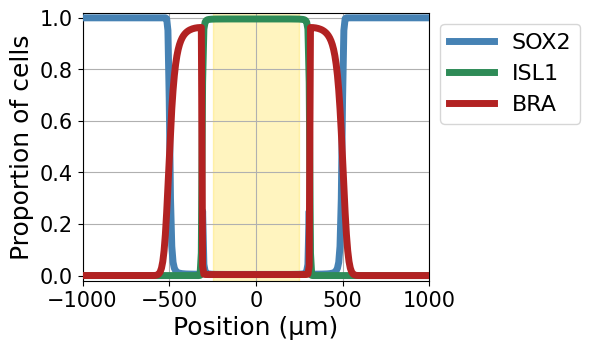

In [6]:
fct.plot_morphogens(x_RCLH, morphogens_RCLH[:,-1], 'RegularCulture_lightBMP4_hightension', x_light=param["x_light"], micro=False)
fct.plot_TFs(x_RCLH, TFs_RCLH[:,-1], 'RegularCulture_lightBMP4_hightension', x_light=param["x_light"], micro=False)
fct.plot_fates(x_RCLH, fates_RCLH[:,-1], 'RegularCulture_lightBMP4_hightension', x_light=param["x_light"], micro=False)

<br>



#### 4. Perturbation 1: no WNT3

In [7]:
# Spatial parameters
param["x_arr_len"] = 300
param["x_total"] = 250.

# PDE parameters
param["micro"] = True
param["fixed_BMP4"] = 50.
param["T_WNT3"] = 0.
param["fixed_nYAP"] = 0.
param["p_NOG"] = 0.07

x_MPF_P1, morphogens_MPF_P1, TFs_MPF_P1, fates_MPF_P1 = fct.get_results(param)

<br>

Figures

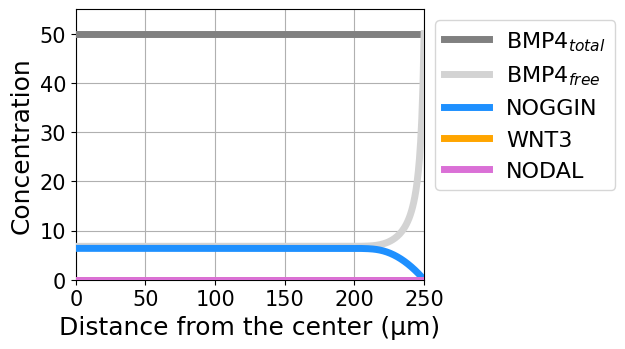

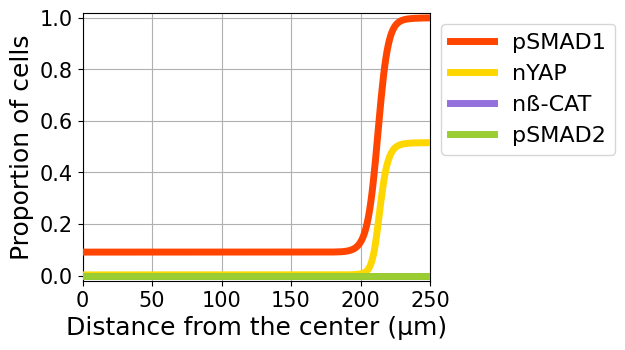

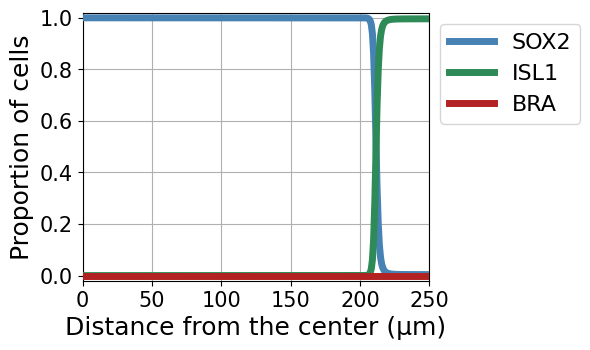

In [8]:
fct.plot_morphogens(x_MPF_P1, morphogens_MPF_P1[:,-1], 'Micropattern_noWNT3', micro=True, fixed_BMP4=True)
fct.plot_TFs(x_MPF_P1, TFs_MPF_P1[:,-1], 'Micropattern_noWNT3', micro=True, fixed_BMP4=True)
fct.plot_fates(x_MPF_P1, fates_MPF_P1[:,-1], 'Micropattern_noWNT3', micro=True, fixed_BMP4=True)

<br>



#### 5. Perturbation 2: more nYAP

In [9]:
# Spatial parameters
param["x_arr_len"] = 300
param["x_total"] = 250.

# PDE parameters
param["micro"] = True
param["fixed_BMP4"] = 50.
param["T_WNT3"] = 3.6
param["fixed_nYAP"] = 0.4
param["p_NOG"] = 0.07

x_MPF_P2, morphogens_MPF_P2, TFs_MPF_P2, fates_MPF_P2 = fct.get_results(param)

<br>

Figures

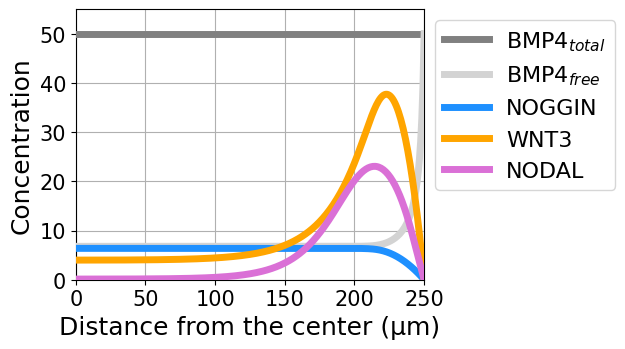

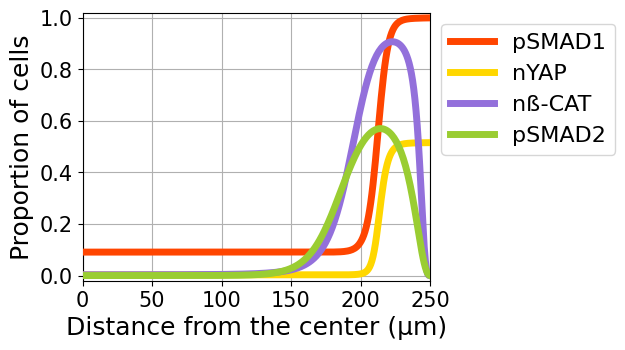

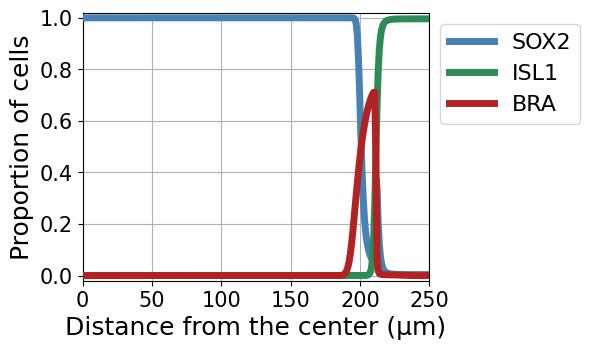

In [10]:
fct.plot_morphogens(x_MPF_P2, morphogens_MPF_P2[:,-1], 'Micropattern_moreYAP', micro=True, fixed_BMP4=True)
fct.plot_TFs(x_MPF_P2, TFs_MPF_P2[:,-1], 'Micropattern_moreYAP', micro=True, fixed_BMP4=True)
fct.plot_fates(x_MPF_P2, fates_MPF_P2[:,-1], 'Micropattern_moreYAP', micro=True, fixed_BMP4=True)

<br>



#### 6. Perturbation 3: no NOGGIN

In [11]:
# Spatial parameters
param["x_arr_len"] = 300
param["x_total"] = 250.

# PDE parameters
param["micro"] = True
param["fixed_BMP4"] = 50.
param["T_WNT3"] = 3.6
param["fixed_nYAP"] = 0.
param["p_NOG"] = 0.

x_MPF_P3, morphogens_MPF_P3, TFs_MPF_P3, fates_MPF_P3 = fct.get_results(param)

<br>

Figures

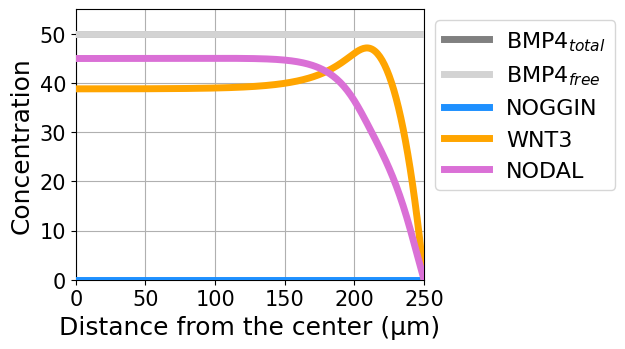

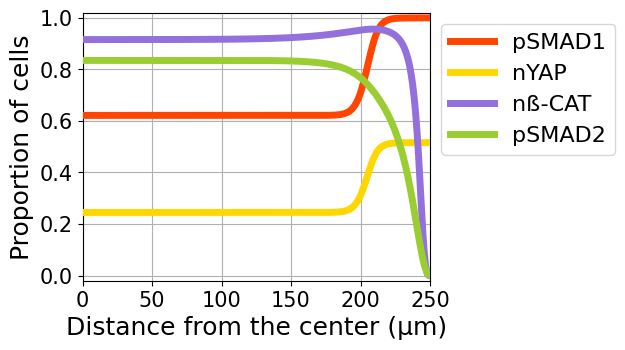

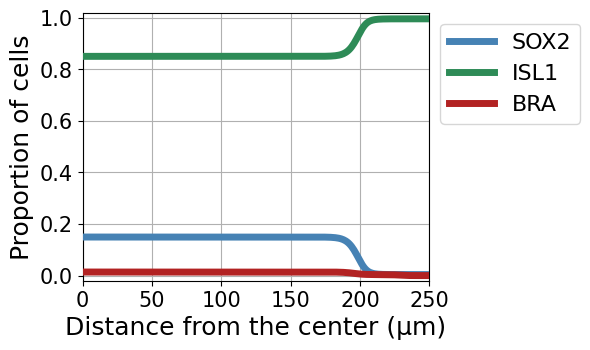

In [12]:
fct.plot_morphogens(x_MPF_P3, morphogens_MPF_P3[:,-1], 'Micropattern_noNOGGIN', micro=True, fixed_BMP4=True)
fct.plot_TFs(x_MPF_P3, TFs_MPF_P3[:,-1], 'Micropattern_noNOGGIN', micro=True, fixed_BMP4=True)
fct.plot_fates(x_MPF_P3, fates_MPF_P3[:,-1], 'Micropattern_noNOGGIN', micro=True, fixed_BMP4=True)